In [70]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyper-parameter tunning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer


# evaluation
from sklearn.metrics import\
    accuracy_score, confusion_matrix, classification_report, \
    f1_score, recall_score, balanced_accuracy_score, precision_score

# storing the best model
import pickle


In [2]:
pd.set_option('display.max_columns', 30)  # Adjust the number as needed
%matplotlib inline

___

In [91]:
sample_submission = pd.read_csv("../data/sample_submission.csv")
sample_submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


In [4]:
train_data = pd.read_csv("../data/train.csv")
train_data.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# Objectives 

- understand the structure of the competition
- load the datasets
- understand the dataset
    - multi-class classification
    - we have 3 categories `C` `CL` `D`
- data preprocessing
- modeling 
- evaluation
- submission as the required submission sample

In [5]:
data = pd.read_csv("../data/train.csv")
data.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# EDA

In [6]:
profile = ProfileReport(data, explorative=True)
profile.to_file("EDA.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:  81%|████████▏ | 22/27 [00:00<00:00, 37.19it/s, Calculate auto correlation]     /Users/artmissg/anaconda3/envs/ml/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'N'')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s]


check the results in EDA.html

# preprocessing

> TODO :  
    - convert N_Days to 3 groups based on if there status, for example if the patient has died or ...
    - convert Age from days to years ?
    - 
>  the given data is already preprocessed and the missing values are filled with the average of others

C  -> alive at N days  
CL -> alive at N days due to liver transplant  
D  -> dead at N days  

In [7]:
data.shape

(7905, 20)

In [8]:
data.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


### Fixing dtypes

In [9]:
# duplicate column
data.drop(columns=["id"], inplace=True)

In [10]:
# convert number of days into years for more clarification
data["N_Days"] = (data["N_Days"] / 365)
data.rename(columns={"N_Days": "N_years"}, inplace=True)

In [11]:
data["Drug"].value_counts()

Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64

In [12]:
# some of the users took actual medicine and others didn't
data["took_drug"] = (data["Drug"] == "D-penicillamine")
data.drop(columns=["Drug"], inplace=True)

In [13]:
# convert age from days into years for more clarification
data["Age"] = (data["Age"] / 365)

In [14]:
data["Sex"] = data["Sex"] == "M"
data.rename(columns={"Sex": "is_male"}, inplace=True)

In [15]:
data["Ascites"] = data["Ascites"] == "Y"
data["Hepatomegaly"] = data["Hepatomegaly"] == "Y"
data["Spiders"] = data["Spiders"] == "Y"

In [16]:
# one hot encode Edema feature into 3 features
encoded_frame = pd.DataFrame(
    OneHotEncoder().fit_transform(data[["Edema"]]).toarray(),
    columns=["no_Edema_no_diuretic", "Edema_no_diuretic", "Edema_diuretic"]
)
data = pd.concat(
    [data, encoded_frame],
    axis=1,
)

data.drop(columns=["Edema"], inplace=True)

In [17]:
data["Status"].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

In [18]:
data.dtypes

N_years                 float64
Age                     float64
is_male                    bool
Ascites                    bool
Hepatomegaly               bool
Spiders                    bool
Bilirubin               float64
Cholesterol             float64
Albumin                 float64
Copper                  float64
Alk_Phos                float64
SGOT                    float64
Tryglicerides           float64
Platelets               float64
Prothrombin             float64
Stage                   float64
Status                   object
took_drug                  bool
no_Edema_no_diuretic    float64
Edema_no_diuretic       float64
Edema_diuretic          float64
dtype: object

In [19]:
# fix True False Features
data = data.astype(
    {
        "is_male": float,
        "Ascites": int,
        "Spiders": int,
        "took_drug": int,
        "Hepatomegaly": int,
    }
)

data = data.convert_dtypes()


In [20]:
# fixing Status dtype using TargetEncoding
encoder = LabelEncoder()
data["Status"] = encoder.fit_transform(data["Status"])

In [21]:
data.head()

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug,no_Edema_no_diuretic,Edema_no_diuretic,Edema_diuretic
0,2.736986,58.991781,1,0,0,0,2.3,316,3.35,172,1601.0,179.8,63,394,9.7,3,2,1,1,0,0
1,7.052055,52.70411,0,0,0,0,0.9,364,3.54,63,1440.0,134.85,88,361,11.0,3,0,0,1,0,0
2,9.391781,37.608219,0,0,1,1,3.3,299,3.55,131,1029.0,119.35,50,199,11.7,4,2,0,0,0,1
3,7.057534,50.575342,0,0,0,0,0.6,256,3.5,58,1653.0,71.3,96,269,10.7,3,0,0,1,0,0
4,2.158904,45.638356,0,0,1,0,1.1,346,3.65,63,1181.0,125.55,96,298,10.6,4,0,0,1,0,0


### Making a pipeline

In [45]:
# Function to preprocess the data
def pre_process(data):
    data.drop(columns=["id"], inplace=True)
    # Convert number of days into years for more clarification
    data["N_Days"] = (data["N_Days"] / 365)
    data.rename(columns={"N_Days": "N_years"}, inplace=True)
    # Some of the users took actual medicine and others didn't
    data["took_drug"] = (data["Drug"] == "D-penicillamine")
    data.drop(columns=["Drug"], inplace=True)
    # Convert age from days into years for more clarification
    data["Age"] = (data["Age"] / 365)
    # Fixing sex feature
    data["Sex"] = data["Sex"] == "M"
    data.rename(columns={"Sex": "is_male"}, inplace=True)
    data["Ascites"] = data["Ascites"] == "Y"
    data["Hepatomegaly"] = data["Hepatomegaly"] == "Y"
    data["Spiders"] = data["Spiders"] == "Y"

    encoded_frame = pd.DataFrame(
        OneHotEncoder().fit_transform(data[["Edema"]]).toarray(),
        columns=["no_Edema_no_diuretic", "Edema_no_diuretic", "Edema_diuretic"]
    )
    data = pd.concat(
        [data, encoded_frame],
        axis=1,
    )
    data.drop(columns=["Edema"], inplace=True)

    # fix True False Features
    data = data.astype(
        {
            "is_male": float,
            "Ascites": int,
            "Spiders": int,
            "took_drug": int,
            "Hepatomegaly": int,
        }
    )

    data = data.convert_dtypes()

    # # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])

    return data  # Return the modified DataFrame

# Column Transformer to apply the pre_process function to the entire DataFrame
pipeline = Pipeline(
    [
        ("preprocessing", FunctionTransformer(func=pre_process, validate=False))
    ]
)

# Model Training

In [23]:
X = data.drop(columns=["Status"])
y = data["Status"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9090)

In [25]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [26]:
rfc.score(X_test, y_test)

0.8179059180576631

In [27]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=20,
    num_class=3,
    learning_rate=0.1,
    booster="gbtree", # gbtree OR gblinear OR dart
    device="gpu",
    early_stopping_rounds=10,
    eval_metric=['merror','mlogloss'],
    seed=9090,
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=0,
)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

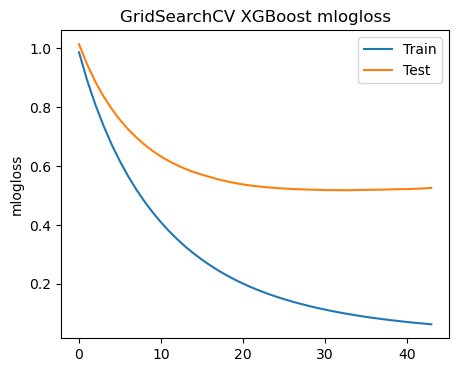

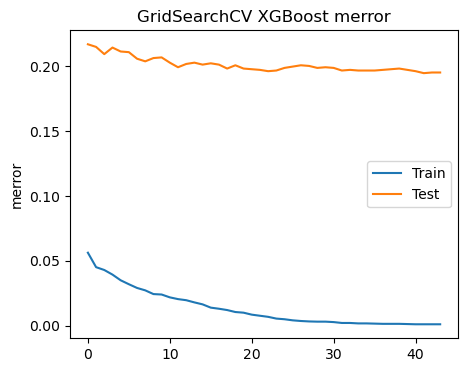

In [28]:
# preparing evaluation metric plots

results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [29]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[1103    9  106]
 [  31   12   26]
 [ 212    5  473]]

Accuracy: 0.80
Balanced Accuracy: 0.59

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.69
Macro Recall: 0.59
Macro F1-score: 0.61

Weighted Precision: 0.79
Weighted Recall: 0.80
Weighted F1-score: 0.79

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1218
           1       0.46      0.17      0.25        69
           2       0.78      0.69      0.73       690

    accuracy                           0.80      1977
   macro avg       0.69      0.59      0.61      1977
weighted avg       0.79      0.80      0.79      1977

---------------------- XGBoost ----------------------


In [30]:
test_pred = xgb_model.predict(X_test)
accuracy_score(test_pred, y_test)

0.8032372281234194

# Hyper-Parameter Tunning

In [12]:
# Bayesian search using skopt
np.int = np.int_ # fo fix the conflict with python version

opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        # "max_depth": Integer(5, 50),
        # "num_class": 3,
        # "learning_rate": Real(0.01, 0.4, prior="uniform"),
        # "booster": Categorical(["gbtree", "gblinear"]),
        # "device": "gpu",
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        # "eval_metric": ['merror','mlogloss'],
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=5,
    random_state=9090,
)

In [32]:
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...................n_estimators=47;, score=0.835 total time=   0.3s
[CV 2/5] END ...................n_estimators=47;, score=0.834 total time=   0.3s
[CV 3/5] END ...................n_estimators=47;, score=0.827 total time=   0.4s
[CV 4/5] END ...................n_estimators=47;, score=0.816 total time=   0.6s
[CV 5/5] END ...................n_estimators=47;, score=0.826 total time=   0.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...................n_estimators=39;, score=0.836 total time=   0.5s
[CV 2/5] END ...................n_estimators=39;, score=0.833 total time=   0.5s
[CV 3/5] END ...................n_estimators=39;, score=0.831 total time=   0.5s
[CV 4/5] END ...................n_estimators=39;, score=0.814 total time=   0.6s
[CV 5/5] END ...................n_estimators=39;, score=0.830 total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_iter=32, random_state=9090, scoring='accuracy',
              search_spaces={'n_estimators': Integer(low=10, high=100, prior='uniform', transform='normalize')},
              verbose=5)

In [38]:
opt.score(X_test, y_test)

0.8153768335862418

In [39]:
opt.best_score_

0.8313050284258686

In [35]:
best_estimator = opt.best_estimator_
y_pred_proba = best_estimator.predict_proba(X_test)

In [36]:
y_pred_proba

array([[9.9244398e-01, 1.4014801e-04, 7.4159196e-03],
       [9.0569425e-01, 2.6857797e-02, 6.7447968e-02],
       [2.3852123e-01, 2.1439509e-03, 7.5933480e-01],
       ...,
       [9.8875219e-01, 3.2931131e-03, 7.9547325e-03],
       [1.1769966e-01, 4.3412130e-02, 8.3888823e-01],
       [6.4513385e-01, 1.7691221e-02, 3.3717492e-01]], dtype=float32)

In [37]:
sample_submission

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128
...,...,...,...,...
5266,13171,0.628084,0.034788,0.337128
5267,13172,0.628084,0.034788,0.337128
5268,13173,0.628084,0.034788,0.337128
5269,13174,0.628084,0.034788,0.337128


# Submission

In [99]:
data_train = pd.read_csv("../data/train.csv")
data_test = pd.read_csv("../data/test.csv")

In [100]:
data_train = pipeline.fit_transform(data_train)
data_test = pipeline.fit_transform(data_test)

In [101]:
X_train = data_train.drop(columns="Status")
y_train = data_train["Status"]
X_test = data_test

In [60]:
# Bayesian search using skopt
np.int = np.int_ # fo fix the conflict with python version

opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        "max_depth": Integer(5, 50),
        "num_class": Categorical([3]),
        "learning_rate": Real(0.01, 0.4, prior="uniform"),
        "booster": Categorical(["gbtree", "gblinear"]),
        "device": Categorical(["gpu"]),
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        # "eval_metric": ['merror','mlogloss'],
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=5,
    random_state=9090,
)

In [61]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gblinear, device=gpu, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.783 total time=   0.2s
[CV 2/5] END booster=gblinear, device=gpu, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.793 total time=   0.2s
[CV 3/5] END booster=gblinear, device=gpu, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.778 total time=   0.1s
[CV 4/5] END booster=gblinear, device=gpu, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.791 total time=   0.1s
[CV 5/5] END booster=gblinear, device=gpu, learning_rate=0.29609945082934797, max_depth=18, n_estimators=77, num_class=3;, score=0.798 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gblinear, device=gpu, learning_rate=0.17757114729954837, max_depth=14, n_estimators=54, num

In [62]:
opt.best_estimator_

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18611805805700052,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=82, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [63]:
opt.best_score_

0.8290955091714105

In [72]:
# storing the model for later usages
with open('best_model.pkl', 'wb') as file :
    pickle.dump(opt, file)

In [102]:
y_pred = opt.predict_proba(X_test)
ans = pd.DataFrame(
    y_pred,
    columns=["Status_C", "Status_CL", "Status_D"]
)

In [106]:
# fixing the id column for the final answer
id_ = pd.read_csv("../data/test.csv")["id"]
ans.insert(0, column="id", value=id_)

In [110]:
ans.to_csv('ans.csv', index=False)